# 3.4 LangGraph 내장 도구(tool)를 활용해서 만드는 Agent

In [7]:
# from dotenv import load_dotenv

# load_dotenv("../.env")

In [8]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")

In [9]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a+b

@tool
def mul(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a*b

In [ ]:
# from dotenv import load_dotenv
# from langchain_tavily import TavilySearch

# load_dotenv("../.env")
# tavily_search = TavilySearch(
#     max_results=5,
#     topic="general",  # "news", "finance"
#     include_answer=True,
#     include_raw_content=True,
#     include_images=True,
#     include_image_descriptions=True,
#     search_depth="advanced"  # "basic"
# )
# tavily_search

In [11]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()
search_tool

DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))

In [14]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import build_resource_service, get_gmail_credentials

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    client_sercret_file="./google/gmail_credentials.json",
    scopes=["https://mail.google.com/"],
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tools = gmail_toolkit.get_tools()
gmail_tools

C:\Users\limjangmook\AppData\Local\Temp\ipykernel_5540\4008356010.py:4: DeprecationWarning: get_gmail_credentials is deprecated and will be removed in a future version.Use get_google_credentials instead.
  credentials = get_gmail_credentials(
C:\Users\limjangmook\AppData\Local\Temp\ipykernel_5540\4008356010.py:9: DeprecationWarning: build_resource_service is deprecated and will be removed in a future version.Use build_gmail_service instead.
  api_resource = build_resource_service(credentials=credentials)


[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x000001B7329DD730>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000001B7329DD730>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x000001B7329DD730>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000001B7329DD730>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x000001B7329DD730>)]

In [15]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

arxiv_tools = [
    ArxivQueryRun(api_wrapper=ArxivAPIWrapper()),
    WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()),
]
arxiv_tools

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000)),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\limjangmook\\Desktop\\ANSWER_25\\inflearn-langgraph-agent\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))]

In [16]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool

collection_name = "real_estate_tax"
embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="부동산 세금 정보 검색기"
)
retriever_tool

StructuredTool(name='real_estate_tax_retriever', description='부동산 세금 정보 검색기', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x000001B733244540>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x000001B73328D120>)

In [17]:
from langgraph.prebuilt import ToolNode

tools = [add, mul, search_tool, retriever_tool] + gmail_tools + arxiv_tools
llm_with_tools = llm.bind_tools(tools=tools)
tool_node = ToolNode(tools=tools)

In [18]:
from langgraph.graph import StateGraph, MessagesState

workflow = StateGraph(state_schema=MessagesState)

In [20]:
def agent(state: MessagesState) -> MessagesState:
    """
    'agent' 함수는 주어진 상태에서 메시지를 가져와, LLM과 도구를 사용하여 응답 메시지를 생성합니다.
    Args:
       state (MessagesState): 메시지 상태를 포함하는 state
    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [21]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition)
workflow.add_edge("tools", "agent")

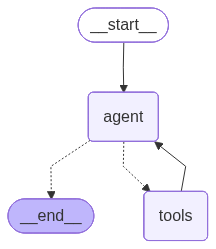

In [22]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# tools = [add, mul, search_tool, retriever_tool] + gmail_tools + arxiv_tools

# query = "3 곱하기 4 한 결과에 5를 곱하면?"
# query = "langgraph에서 사용할 무료 웹 검색 tool 추천해 줘"
# query = "15억짜리 아파트 부동산 세금은 얼마야?"
# query = " 'Attention Is All You Need' 논문을 먼저 요약하고, 그 결과를 'limjangmook@gmail.com'으로 보내주세요"

In [26]:
from langchain_core.messages import HumanMessage

query = "3 곱하기 4 한 결과에 5를 곱하면?"
for response in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

3 곱하기 4 한 결과에 5를 곱하면?
================================== Ai Message ==================================
Tool Calls:
  mul (7f8471a0-862a-4ef6-89b0-94d4b5e33f66)
 Call ID: 7f8471a0-862a-4ef6-89b0-94d4b5e33f66
  Args:
    a: 12
    b: 5
================================= Tool Message =================================
Name: mul

60
================================== Ai Message ==================================

기존의 문제에서 3과 4를 먼저 곱한 후, 그 결과인 12을 5로 곱하면 60이 됩니다.


In [27]:
query = "langgraph에서 사용할 무료 웹 검색 tool 추천해 줘"
for response in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

langgraph에서 사용할 무료 웹 검색 tool 추천해 줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (a6950e55-7022-48ad-8758-b3448a49c753)
 Call ID: a6950e55-7022-48ad-8758-b3448a49c753
  Args:
    query: free web search tools for langgraph
================================= Tool Message =================================
Name: duckduckgo_search

Adding Search Node This time, we'll perform a Web Search using the TavilySearch tool. Below is an example using the TavilySearch tool. This repository enables AI-powered search and insights generation using LangGraph and OpenAI's GPT-4o, leveraging both Tavily and DuckDuckGo search tools . The project facilitates intelligent web searching and content processing to provide insightful responses based on user queries. Sep 4, 2025 · When building an autonomous AI agent with a framework like LangGraph , we focus on the gra

In [28]:
query = "15억짜리 아파트 부동산 세금은 얼마야?"
for response in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

15억짜리 아파트 부동산 세금은 얼마야?
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (75abb296-ed89-4343-abd1-e8a43009adc8)
 Call ID: 75abb296-ed89-4343-abd1-e8a43009adc8
  Args:
    query: 거번치호드 먹장구보해라
================================= Tool Message =================================
Name: real_estate_tax_retriever

납부기간 개시 5일 전까지 발급하여야 한다.<개정 2020. 12. 29.>
③제1항 및 제2항에도 불구하고 종합부동산세를 신고납부방식으로 납부하고자 하는 납세의무자는 종합부동산세의
과세표준과 세액을 해당 연도 12월 1일부터 12월 15일까지 대통령령으로 정하는 바에 따라 관할세무서장에게 신고
하여야 한다. 이 경우 제1항의 규정에 따른 결정은 없었던 것으로 본다.<개정 2020. 6. 9.>
④제3항의 규정에 따라 신고한 납세의무자는 신고기한까지 대통령령으로 정하는 바에 따라 관할세무서장ㆍ한국은
행 또는 체신관서에 종합부동산세를 납부하여야 한다.<개정 2020. 6. 9.>
⑤제1항 및 제2항의 규정에 따른 종합부동산세의 부과절차 및 징수에 관하여 필요한 사항은 대통령령으로 정한다.
[전문개정 2007. 1. 11.]
 
제16조의2(물적납세의무에 대한 납부특례) ① 제7조제2항 또는 제12조제2항에 따라 종합부동산세를 납부하여야 하는
위탁자의 관할 세무서장은 제7조의2 또는 제12조의2에 따라 수탁자로부터 위탁자의 종합부동산세등을 징수하려면
다음 각 

In [31]:
query = " 'Attention Is All You Need' 논문을 먼저 요약하고, 그 결과를 'limjangmook@gmail.com'으로 보내주세요"
for response in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

 'Attention Is All You Need' 논문을 먼저 요약하고, 그 결과를 'limjangmook@gmail.com'으로 보내주세요
================================== Ai Message ==================================
Tool Calls:
  create_gmail_draft (2f7d6ed3-81d0-4c4e-88de-25f0517bf3b0)
 Call ID: 2f7d6ed3-81d0-4c4e-88de-25f0517bf3b0
  Args:
    message: Attention Is All You Need 논문 요약입니다.

자세한 내용은...

https://arxiv.org/abs/1706.03762
    subject: 논문 요약
    to: ['limjangmook@gmail.com']
================================= Tool Message =================================
Name: create_gmail_draft

Draft created. Draft Id: r-2359330796664745396
================================== Ai Message ==================================

'Attention Is All You Need' 논문은 Transformer 아키텍처를 소개하는 논문입니다. 이전의 시퀀스-to-시퀀스 모델은 RNN을 사용하여 한 번에 하나씩 순회했지만, 이 논문에서는 Self-Attention Mechanism을 통해 모든 위치에 동시에 주의를 집중할 수 있는 Transformer 아키텍처를 제안합니다.

Transformer는 여러 단계로 구성되며 각 단계에서 Self-Attention Mecha